# Firo forensics

Isthmus // March 2021

This research examines the large reorganization of the Firo chain in Jan 2021. The relevant background for understanding this analysis is discussed in the post-mortem: [https://forum.firo.org/t/firo-51-attack-post-mortem-and-vote-on-attackers-funds/1084](https://forum.firo.org/t/firo-51-attack-post-mortem-and-vote-on-attackers-funds/1084)

Since a reorganization of this type is considered a "50%+1 attack" on Nakamoto consensus, we will adopt the technical term and refer to the "attacker's" blocks versus the control case of general chain statistics.

First, we'll conclusively identify which blocks were mined by the attacker based on two signature types: the miner address, and a fingerprint on the coinbase transaction.
They were mainly active during a 357 block window from 338403 to 338760. During that time, they mined 98.6% of blocks. The only blocks in that interval that they did not mine were: 338720, 338750, 338753, 338756, 338759.
Further examination of blocks mined in 2021 did not show any trace of either fingerprint outside of 338403-338760 with the single exception of block 337396 which contained the coinbase fingerprint but a different miner address.

Second, we'll analyze the nonces and observe that the attacker employed a nonce search strategy of starting at zero and incrementing upwards with each hash (one of four strategies observed in the wild in the Firo ecosystem).
The nonces in the attacker's blocks are distributed throughout more of the range (relative to the Firo network baseline / control case), which suggests that the attacker achieved the same hashrate with fewer devices.
This phenomenon inspired a miner nonce search strategy simulator that explores this idea further: https://github.com/Mitchellpkt/PoW-search-simulator/blob/main/PoW%20search%20simulator.ipynb


Third, we'll compare the timestamps across the fork to compare progress of the two chains. If the timestamps are accurate, then the attack chain was significantly ahead of the organic chain (by as far as 40+ blocks) for much of the reorganized window.


Questions / comments / suggestions? Contact: firo-forensics@mitchellpkt.com

Support: `aCRUhBHi5WXS9Prq3HbXQkTG7TfHtfUDBx` (Firo)

## Import Libraries

In [1]:
import os as os
import pandas as pd
import matplotlib.pyplot as plt
import isthmuslib as isli
import numpy as np
import requests as requests

## Misc

Color theme

In [2]:
pd.set_option('display.max_rows', None)
firo_red = (155/256, 28/256, 46/256)
firo_red_array = np.array([firo_red])
firo_gray = (244/256, 244/256, 244/256)

Disable scrolling in Jupyter notebooks

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import data

In [4]:
datapath = os.path.join('..', 'data')
active_blocks = pd.read_csv(os.path.join(datapath, 'firo_active_chain.csv'), delimiter=';')
active_blocks.rename(columns=lambda x: x.strip(), inplace=True)
abandoned_blocks = pd.read_csv(os.path.join(datapath, 'firo_abandoned.csv'), delimiter=';')
abandoned_blocks.rename(columns=lambda x: x.strip(), inplace=True)

Pull out attack blocks

In [5]:
attack_blocks = active_blocks[active_blocks['height'].isin(abandoned_blocks['height'])]

## Which blocks did the attacker mine?

The attacker always mined with address `aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq` and included the string `anon` in the coinbase transaction.

This next cell will serially query a blockchain explorer for info about the blocks in the range that the miner was online. It is disabled by default to avoid unnecessary pings, set `collect_block_info = True` to activate.

### Approach 1: Collect or insert data based on attacker address

See summary information in output cell

In [6]:
collect_block_info = False 
earliest_block = 338403 # This is adjusted to set the scan window width
latest_block = 338760 # This is adjusted to set the scan window width
others_heights = list()

if collect_block_info:
    for h in range(earliest_block, latest_block+1):
        r = requests.get("https://www.coinexplorer.net/FIRO/block/" + str(h))
        if 'aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq' not in r.text:
            others_heights.append(h)
else:
    # Skip the data collection and insert the result
    others_heights = [338720, 338750, 338753, 338756, 338759]
    
attacker_activity_window = latest_block - earliest_block + 1
others_count = len(others_heights)
attacker_count = attacker_activity_window - others_count
attacker_fraction = attacker_count / attacker_activity_window

print('\n*************************************')
print('*************************************\n')
print('The attacker was active during a ' + str(attacker_activity_window) + ' block window from ' + str(earliest_block) + ' to ' + str(latest_block))
print('\nDuring that time, they mined ' + str(round(attacker_fraction*10000)/100) + '% of blocks ('+str(attacker_count)+ ' of ' + str(attacker_activity_window) +')')
print('\nThe only blocks that they did not mine were: ')
print('     ' + str(others_heights))
print('\n*************************************')
print('*************************************')


*************************************
*************************************

The attacker was active during a 358 block window from 338403 to 338760

During that time, they mined 98.6% of blocks (353 of 358)

The only blocks that they did not mine were: 
     [338720, 338750, 338753, 338756, 338759]

*************************************
*************************************


### Approach 2: Collect or insert data based on coinbase metadata

The attacker's coinbases always end with `4616e6f6e` (`anon`), for example:
+ height 337396 [https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73](https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73)
+ height 338403 [https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745](https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745)

First, we define `check_coinbase_tag()` to check for the `4616e6f6e`/`anon` fingerprint

In [7]:
def check_coinbase_tag(block_height):
    r = requests.get("https://www.coinexplorer.net/FIRO/block/" + str(block_height))
    if 'anon</code' in r.text:
        return True
    else:
        return False

**Loop over heights of interest to check if the blocks have said fingerprint**

In [8]:
collect_block_info = True
verbosity = 1
earliest_block = 338400
latest_block = 338405
others_heights = list()
attacker_heights = list()

if collect_block_info:
    for h in range(earliest_block, latest_block):
        has_tag = check_coinbase_tag(h)
        if has_tag:
            attacker_heights.append(h)
            
        if verbosity:
            print('Height: ' + str(h) + " // Coinbase includes attacker's tag? " + str(has_tag))
else:
    # Skip the data collection and insert the result
    pass

Height: 338400 // Coinbase includes attacker's tag? False
Height: 338401 // Coinbase includes attacker's tag? False
Height: 338402 // Coinbase includes attacker's tag? False
Height: 338403 // Coinbase includes attacker's tag? True
Height: 338404 // Coinbase includes attacker's tag? True


**Does block 337396 (from before the attack) have the coinbase tag fingerprint?** (yes)

In [9]:
check_coinbase_tag(337396)

True

## Nonce visualizations

### Baseline nonce distribution
Looking at nonces from all blocks (see histogram below), it appears that 4 nonce search strategies are in use:
+ Start at 0 and iterate upwards (evidenced by the peak at 0 sloping down to 1e9)
+ Start at the halfway point and iterate upwards (evidenced by the smaller sawtooth at 2.15e9, see blue line for visual guide)
+ Start at the upper range and iterate downwards (evidenced by the mirrored sawtooth at the upper limit)
+ Sample randomly over the entire range (the baseline signal throughout the range)

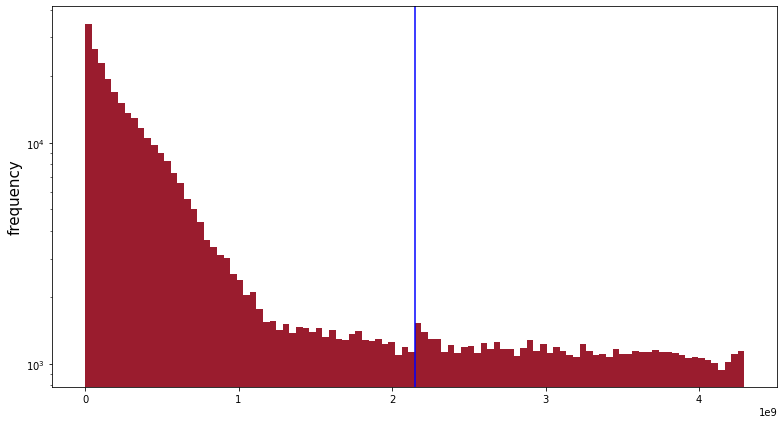

In [10]:
f = isli.hist(active_blocks['nonce'], yscale='log', bins=100, color=firo_red)
plt.axvline(x=max(active_blocks['nonce'])/2, color='blue');

To make sure that we're only taking into account relevant data we must ask whether the nonce search strategy changed over time?

Yes! A few observations from the below plot:
+ Between heights 7,500 (red line) and 21,000 (lime line) the dominant strategy appears to be a uniform search over *only* the bottom half of the nonce range. I don't think I have observed this in any other cryptocurrency.
+ Between heights 21,000 (lime line) and 120,000 (yellow line) the search was extended to cover the entire nonce range (uniformly).
+ While the strategy of iterating upwards from low nonces has always been present to some extent, it really picked up as the dominant strategy around height 120,000 (yellow line) onwards. (You can also see the subtle trace of the middle-upwards strategy).

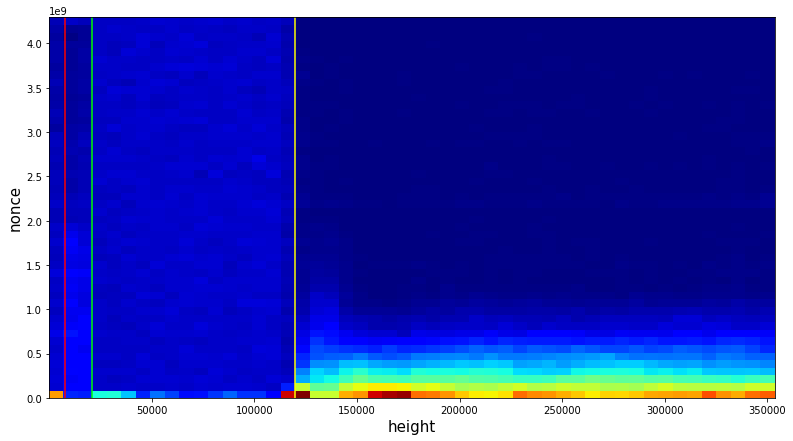

In [11]:
f = isli.hist2d(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='nonce', cmap='jet')
plt.axvline(x=7_500, color='red')
plt.axvline(x=21_000, color='lime')
plt.axvline(x=120_000, color='yellow');

### Attack block nonce distribution
It appears that the attacker was using software that employs the (dominant) strategy of starting at 0 and iterating upwards, as shown below

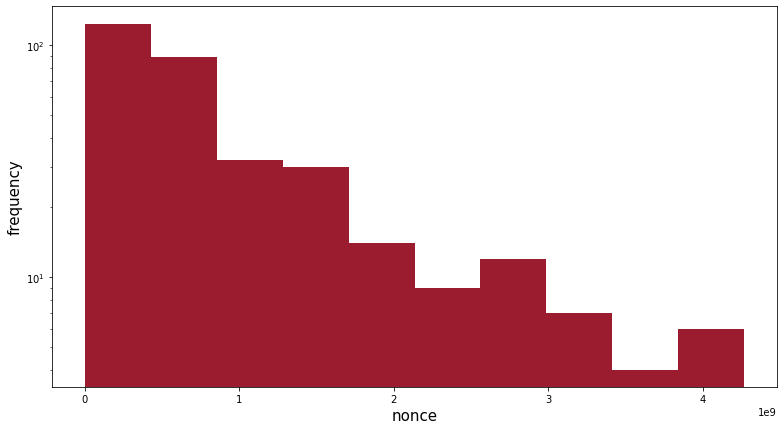

In [12]:
isli.hist(attack_blocks['nonce'], yscale='log', xlabel = 'nonce', color=firo_red, bins = 10);

We want apples-to-apples comparisons when overlaying the nonce patterns, so we'll select our "control case" for nonce patterns from a 30,000 block window centered around the start of the attack, to remove historical artifacts. We also exclude the attacker's blocks.

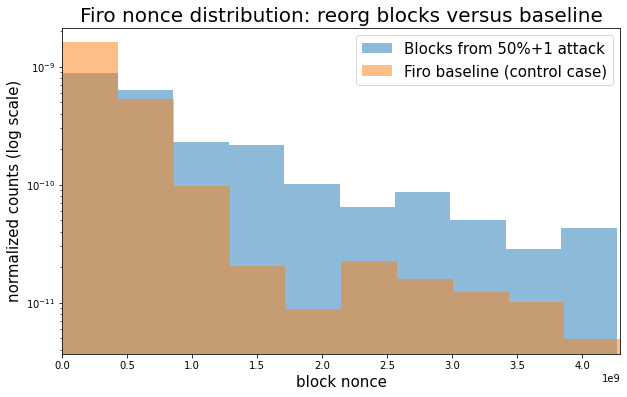

In [13]:
window_width = 15_000 # blocks

# Collect indices
first_attack_block = min(attack_blocks['height'])
last_attack_block  = max(attack_blocks['height'])

# Collect indices
first_attack_block = min(attack_blocks['height'])
last_attack_block  = max(attack_blocks['height'])
window_left = first_attack_block - window_width/2
window_right = first_attack_block + window_width/2

# Left side of the control case (start of control window to start of attack)
tempdf = active_blocks[active_blocks['height']>window_left]
control_left = tempdf[tempdf['height']<first_attack_block]

# Right side of the control case (end of attack to end of control window)
tempdf = active_blocks[active_blocks['height']<window_right]
control_right = tempdf[tempdf['height']>last_attack_block]

# Combine
control_blocks = pd.concat([control_left, control_right])

# Plot
dataDict = {"Attack blocks": attack_blocks['nonce'], "Control blocks": control_blocks['nonce']}
isli.hist(dataDict, yscale='log', xlabel = 'block nonce', alpha=0.5, bins = 10, density=True, ylabel='normalized counts (log scale)', figsize=(10,6), title='Firo nonce distribution: reorg blocks versus baseline', xlim=(0,2**32));
plt.legend(['Blocks from 50%+1 attack', 'Firo baseline (control case)'], fontsize=15);

While the attacker and the control blocks both appear to use the same nonce search strategy of iterating upwards from zero, the slope of their discovered nonces differ significantly, which has subtle statistical implications. 

The control blocks have nonces weighted towards zero, because there are many independent workers all searching up from 0 together and it is likely that *somebody* will find a block sooner rather than later. 

The attack blocks have a less steep dropoff, which suggests that the hashrate was divided up between fewer workers (giving each a statistically greater chance of making it further through nonce range iteration).

**This suggests that the attacker's 50%+1 hashrate match came from *fewer* devices with *more* hashrate than the network average distribution (which effectively rules out a botnet attack, for example).**

(As an aside, we notice that in PoW networks with "iterate from zero" as the dominant search strategy, the steepness of the dropoff in the histogram is a statististical proxy for decentralization and the number of miner workers!! This is explored more thoroughly through simulations [here](https://github.com/Mitchellpkt/PoW-search-simulator/blob/main/PoW%20search%20simulator.ipynb))

The difference highlighted in the above histogram is visually apparent on a nonce scatter plot. See the change in density in the center of the graph? Those are the attackre's blocks; the fact that more of the search space was utilized during that small stretch is visible to the naked eye. (Second plot shows the duration of the attack boxed in blue, as a visual guide)

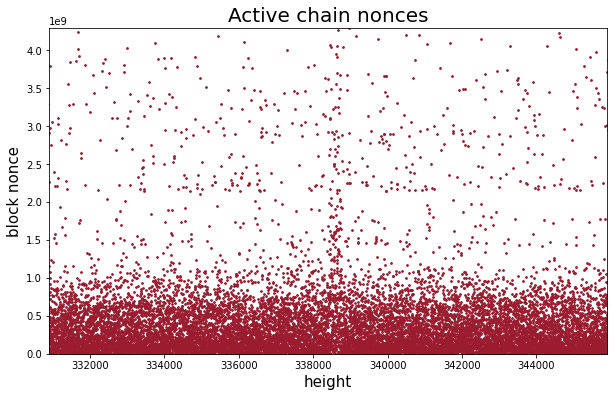

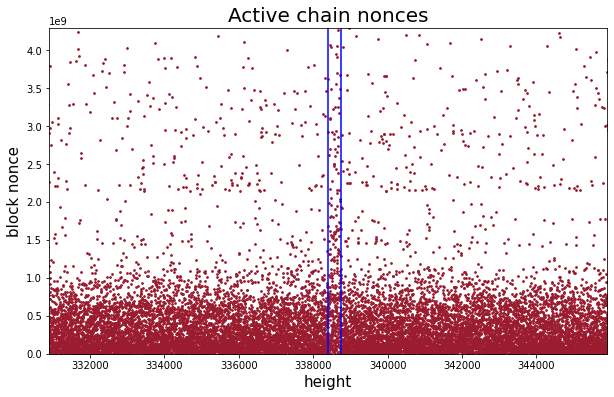

In [14]:
# Plot twice; once without visual aids, once with (blue lines)
f = isli.scatter(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='block nonce', xlim=(window_left, window_right),ylim = (min(active_blocks['nonce']), max(active_blocks['nonce'])), markercolor=firo_red_array,  figsize=(10,6), title='Active chain nonces');
f = isli.scatter(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='block nonce', xlim=(window_left, window_right),ylim = (min(active_blocks['nonce']), max(active_blocks['nonce'])), markercolor=firo_red_array,  figsize=(10,6), title='Active chain nonces');
plt.axvline(x=first_attack_block, color='b')
plt.axvline(x=last_attack_block, color='b');

## What was the hashrate of an individual worker?
With miners that increment (or decrement) the nonce with each hash, the hashrate of an individual worker can be estimated. In the case of incrementing upwards from zero, the calculation of hashrate (give or take latency and processing time) is trivial:

`worker_hashrate = nonce / block_discovery_time`

### Attacker estimated individual worker hashrate

First some quick feature engineering

In [15]:
nonce_threshold = 1e9 # << anything above this unlikely to have been mined by iterating upwards from zero
 
# Attacker blocks
attacker_heights = list(set(range(338403, 338760+1)) - set(others_heights))
attacker_blocks_df = pd.DataFrame()
for height_index in range(len(attacker_heights)):
    thisHeight = attacker_heights[height_index]
    attacker_blocks_df = attacker_blocks_df.append(active_blocks[active_blocks['height'] == thisHeight])
attacker_blocks_df['discovery_time'] = attacker_blocks_df['time'].diff()
attacker_blocks_df['estimated_hashes_per_sec'] = attacker_blocks_df['nonce']  / attacker_blocks_df['discovery_time']

# Honest blocks
honest_blocks_df = control_blocks.append(abandoned_blocks)
honest_blocks_df = honest_blocks_df.sort_values(by='height', ascending=True)
honest_blocks_df['discovery_time'] = honest_blocks_df['time'].diff()
honest_blocks_df['estimated_hashes_per_sec'] = honest_blocks_df['nonce']  / honest_blocks_df['discovery_time']
honest_blocks_df = honest_blocks_df[honest_blocks_df['nonce']  < nonce_threshold]
honest_heights = honest_blocks_df['height']

Visualize results

Median worker hashrate for attack blocks: 2669546.427184466
Mean worker hashrate for attack blocks: 19050077.994437695


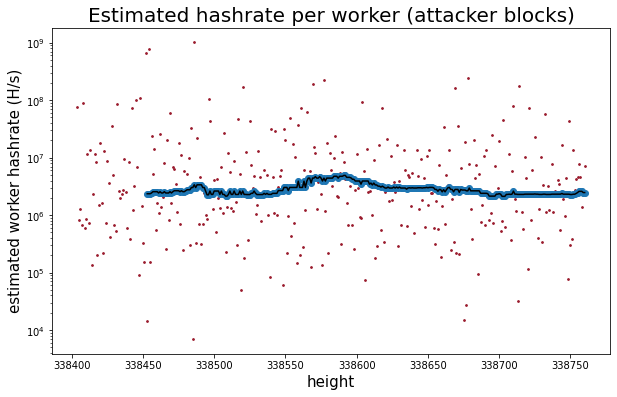

In [16]:
isli.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::], xlabel='height', ylabel='estimated worker hashrate (H/s)', markercolor=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (attacker blocks)', yscale='log', rollingMedianBinWidth=50);
print('Median worker hashrate for attack blocks: ' + str(np.nanmedian(attacker_blocks_df['estimated_hashes_per_sec'])) + '\nMean worker hashrate for attack blocks: ' + str(np.nanmean(attacker_blocks_df['estimated_hashes_per_sec'])))

### Honest chain estimated individual worker hashrate

Median worker hashrate for honest blocks: 1050258.9483016338
Mean worker hashrate for honest blocks: 4073206.6830584486
Number of blocks: 14109


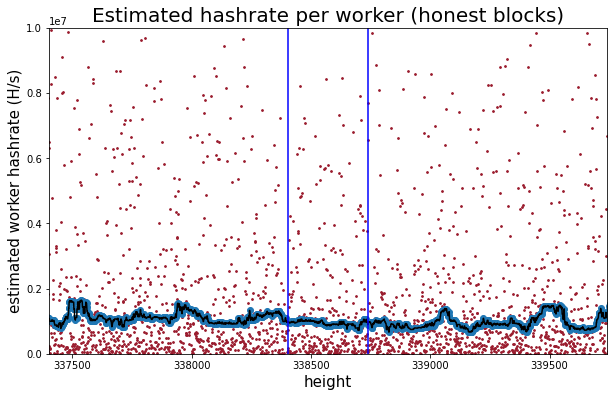

In [17]:
rolling_average_width = 100
xlim_width = 1000
isli.scatter(honest_blocks_df['height'][1::]-rolling_average_width/2, honest_blocks_df['estimated_hashes_per_sec'][1::], 
             rollingMedianBinWidth=rolling_average_width, xlabel='height', ylabel='estimated worker hashrate (H/s)', markercolor=firo_red_array, 
             figsize=(10,6), title='Estimated hashrate per worker (honest blocks)', yscale='linear', ylim=(0, 1e7))
plt.axvline(x=min(attack_blocks['height']), color='b')
plt.axvline(x=max(attack_blocks['height']), color='b')
print('Median worker hashrate for honest blocks: ' + str(np.nanmedian(honest_blocks_df['estimated_hashes_per_sec'])) + '\nMean worker hashrate for honest blocks: ' + str(np.nanmean(honest_blocks_df['estimated_hashes_per_sec'])))
plt.xlim((first_attack_block-xlim_width,last_attack_block+xlim_width));
print('Number of blocks: ' + str(len(honest_blocks_df)))

### Combined plots

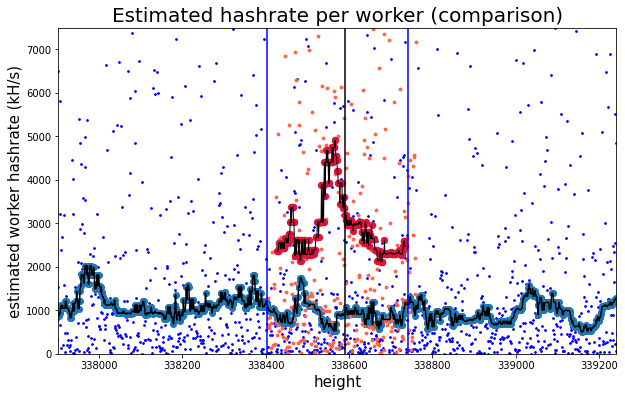

In [18]:
rolling_average_width = 50
xlim_width = 500

# First plot the honest blocks
isli.scatter(honest_blocks_df['height'][1::]-rolling_average_width/2, honest_blocks_df['estimated_hashes_per_sec'][1::]/1000, 
             rollingMedianBinWidth=rolling_average_width, xlabel='height', ylabel='estimated worker hashrate (kH/s)', markercolor='b', 
             figsize=(10,6), title='Estimated hashrate per worker (comparison)', yscale='linear', ylim=(0, 7.5e3))
plt.axvline(x=min(attack_blocks['height']), color='b')
plt.axvline(x=max(attack_blocks['height']), color='b')
plt.xlim((first_attack_block-xlim_width,last_attack_block+xlim_width));

# Now add the attacker blocks
plt.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000, color='tomato', s = 8)
temporaryDataFrame = pd.DataFrame()
temporaryDataFrame['xData'] = attacker_blocks_df['height'][1::]-rolling_average_width/2
temporaryDataFrame['yData'] = attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000
temporaryDataFrame.sort_values(by='xData', ascending=True, inplace=True)
trace = plt.scatter(temporaryDataFrame.xData,
                    temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
                    color='crimson', s=40)
trace = plt.plot(temporaryDataFrame.xData, temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
         color='k',linewidth=1)
plt.axvline(x=338590, color='k');

In [19]:
print('Attacker block stats\nMedian discovery time: ' + str(np.nanmedian(attacker_blocks_df['discovery_time'])) + ' s' + '\nMedian estimated hashrate: ' + str(round(np.nanmedian(attacker_blocks_df['estimated_hashes_per_sec']/1000))) + ' kH/s\n')
attacker_blocks_df.describe()

Attacker block stats
Median discovery time: 210.0 s
Median estimated hashrate: 2670 kH/s



,height,time,nonce,discovery_time,estimated_hashes_per_sec
count,358.000000,3.580000e+02,3.580000e+02,357.000000,3.570000e+02
mean,338581.500000,1.611044e+09,8.971881e+08,322.425770,1.905008e+07
std,103.489935,3.492205e+04,9.228484e+08,418.612701,8.065340e+07
min,338403.000000,1.610990e+09,1.244494e+06,3.000000,6.991539e+03
25%,338492.250000,1.611015e+09,2.333833e+08,76.000000,8.272767e+05
50%,338581.500000,1.611038e+09,5.919560e+08,210.000000,2.669546e+06
75%,338670.750000,1.611079e+09,1.236449e+09,416.000000,9.350080e+06
max,338760.000000,1.611106e+09,4.266500e+09,4711.000000,1.010355e+09


In [20]:
print('Honest block stats\nMedian discovery time: ' + str(np.nanmedian(honest_blocks_df['discovery_time'])) + ' s' + '\nMedian estimated hashrate: ' + str(round(np.nanmedian(honest_blocks_df['estimated_hashes_per_sec']/1000))) + ' kH/s\n')
honest_blocks_df.describe()

Honest block stats
Median discovery time: 212.0 s
Median estimated hashrate: 1050 kH/s



,height,time,nonce,discovery_time,estimated_hashes_per_sec
count,14109.000000,1.410900e+04,1.410900e+04,14108.000000,1.410800e+04
mean,338410.341839,1.611025e+09,2.913237e+08,302.121917,4.073207e+06
std,4346.504472,1.308976e+06,2.399090e+08,304.374673,1.173797e+07
min,330904.000000,1.608742e+09,6.851000e+03,2.000000,1.650843e+01
25%,334637.000000,1.609910e+09,9.179343e+07,80.000000,3.413627e+05
50%,338409.000000,1.610993e+09,2.218263e+08,212.000000,1.050259e+06
75%,342199.000000,1.612154e+09,4.518783e+08,410.000000,3.226006e+06
max,345902.000000,1.613268e+09,9.987649e+08,3250.000000,3.443735e+08


## Cross-chain timestamp analysis
**Everything in this section must be prefaced with the caveat that block timestamps are entirely spoofable, so this could have been faked.**

The timestamps appear to show an organic trend which suggests to that the attacker did not take deliberate steps to falsify the timestamps. This means we can examine their block production schedule and thus make inferences about their hashrate. If this is true, then it appears they had roughly 51% to 55%(?) of the global hashrate at the time of the attack. (_to-do: estimate hashrate from block production rate_)

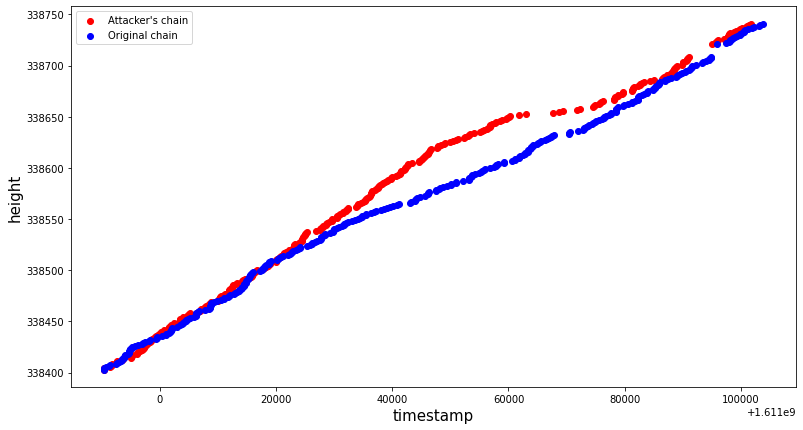

In [21]:
data_dictionary = [
    {'y': attack_blocks['height'],
     'x': attack_blocks['time'],
     'markercolor': 'r',
     'label': "Attacker's chain"},

    {'y': abandoned_blocks['height'],
        'x': abandoned_blocks['time'],
        'markercolor': 'b',
        'label': "Original chain"}
]

isli.scatterDictionary(data_dictionary, legend=True, xlabel='timestamp', ylabel='height');

For a moment, let's take a zoom out slightly on the above plot to the bigger picture (below) to see if the hashrate was from new equipment, or withdrawn from pools? 

Imagine that the attacker had no new equipment/hashrate, but controlled 50%+1 of the equipment that was already active. In this case, when the attack starts, the rate of block production would be cut in half (which would cause the slope of the abandoned blocks to be cut in half from the the slope observed outside of the attack). 

The above scenario is NOT what is observed in the data. The below plot shows that the block production schedule of the original (abandoned)  chain did not change during the attack (between red lines). **This tells us that for the most part, the attacker had fresh equipment/hashrate that was not mining on the main chain immediately before or after the attack.**

(Note that around height 338550 there is in fact a small dip in the honest hashrate when the attacker's hashrate picks up some steam. This is a small delta and the statistical significance is unclear (it is not explored further here). If anything, it would mean that a small amount of organic hashrate joined the attacker partway through, however this would require back channel communication and coordination since the chain was not public at the time.)

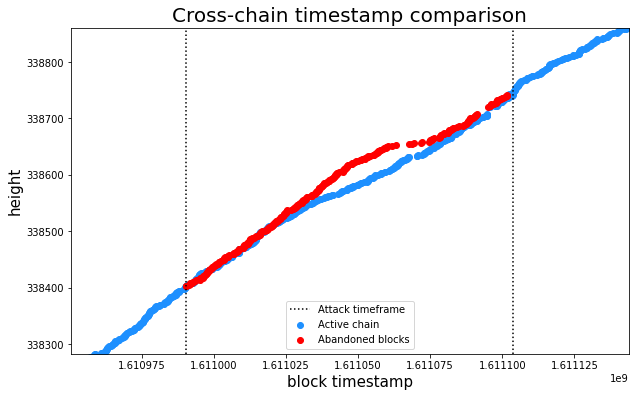

In [22]:
data_dictionary = [
    {'y': honest_blocks_df['height'],
     'x': honest_blocks_df['time'],
     'markercolor': 'dodgerblue',
     'label': "honest blocks"},

    {'y': attack_blocks['height'],
    'x': attack_blocks['time'],
    'markercolor': 'r',
    'label': "attacker blocks"}
]

height_buffer = 120
time_buffer = 40000
isli.scatterDictionary(data_dictionary, legend=True, xlabel='block timestamp', ylabel='height', 
                       xlim=(min(abandoned_blocks['time'])-time_buffer, max(abandoned_blocks['time'])+time_buffer), 
                       ylim=(min(abandoned_blocks['height'])-height_buffer, max(abandoned_blocks['height'])+height_buffer), figsize=(10,6), title='Cross-chain timestamp comparison')

plt.axvline(x=min(abandoned_blocks['time']), color='k', linestyle=':')
plt.legend(('Attack timeframe', 'Active chain', 'Abandoned blocks'))
plt.axvline(x=max(abandoned_blocks['time']), color='k', linestyle=':');

Let's look at the difference between the above two lines. In other words, when the honest chain was at height `h` how many blocks ahead or behind was the attacker. This will require a bit of data wrangling...

### Analysis data frame feature engineering
At a given time, calculate how far ahead or behind he attacker was

In [23]:
# initialize
t_values = list()
abandoned_height_values = list()
attacker_height_values = list()
analysis_df = pd.DataFrame()

for row_index in range(len(abandoned_blocks)):
    # Compare the chains
    t_abandoned = abandoned_blocks['time'][row_index]
    h_abandoned = abandoned_blocks['height'][row_index]
    attack_thus_far = attack_blocks[attack_blocks['time'] <= t_abandoned]
    if len(attack_thus_far) > 0:
        # Append to buffers
        h_attacker = max(attack_thus_far['height'])
        t_values.append(t_abandoned)
        abandoned_height_values.append(h_abandoned)
        attacker_height_values.append(h_attacker)
    
# Add to data frame
analysis_df['time'] = t_values
analysis_df['abandoned_height'] = abandoned_height_values
analysis_df['attacker_height'] = attacker_height_values

# Calculate difference
analysis_df['attacker_lead'] = analysis_df['attacker_height'] - analysis_df['abandoned_height']

### Attack progress visualization

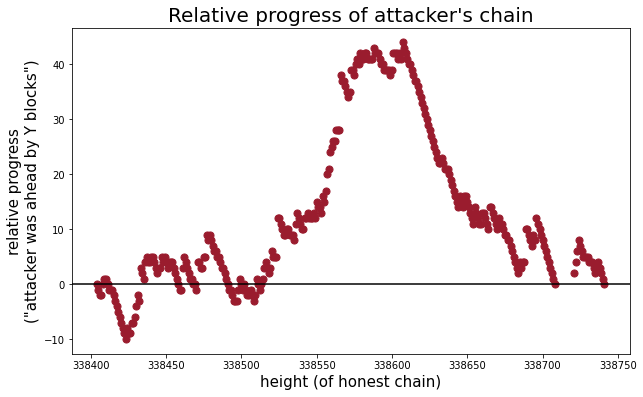

In [24]:
isli.scatter(analysis_df['abandoned_height'], analysis_df['attacker_lead'], xlabel='height (of honest chain)', ylabel='relative progress\n("attacker was ahead by Y blocks")', markersize=50, markercolor=firo_red_array, figsize=(10,6), title="Relative progress of attacker's chain");
plt.axhline(y=0, color='k');

There's a few things to unpack with the above figure. 

For the first third of the attack, it appears that the attacker had about as much hashrate as the honest chain. In some cases the attacker fell behind by as much as 10 blocks but continued to persevere.

Around height 338510 it appears that the attacker's hashrate relative to the honest chain increased significantly, and they achieved a lead of 44 blocks at one point! 

Shortly after achieving the peak, the attacker's lead starts to wane, as their block production rate slowed relative to the honest chain.

Note / recall that although the reorgs stopped  at 338741, the attacker continued to be the dominant miner through block 338760 (the next 19 blocks ~ 1.5 hrs)

# Aux plots

Go ahead and ignore these ... anything below this line is rough drafts, not polished up

```
















































```

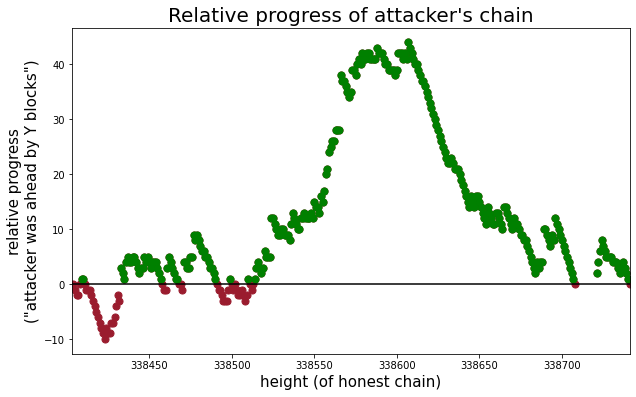

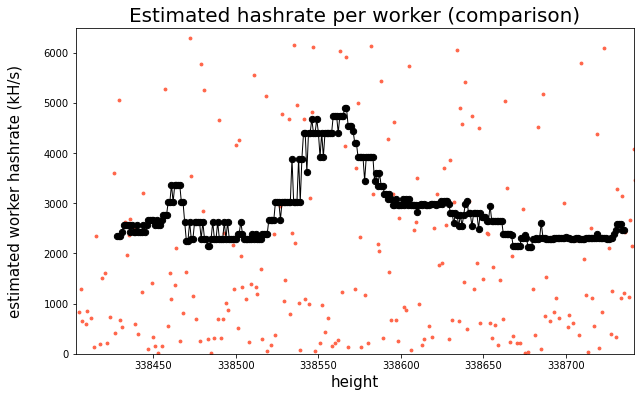

In [25]:
isli.scatter(analysis_df['abandoned_height'], analysis_df['attacker_lead'], xlabel='height (of honest chain)', ylabel='relative progress\n("attacker was ahead by Y blocks")', markersize=50, markercolor=firo_red_array, figsize=(10,6), title="Relative progress of attacker's chain");
leadDataFrame = analysis_df[analysis_df['attacker_lead']>0]
plt.scatter(leadDataFrame['abandoned_height'], leadDataFrame['attacker_lead'], s=50, color='g');
plt.axhline(y=0, color='k');
plt.xlim((min(attack_blocks['height']), max(attack_blocks['height'])));

rolling_average_width = 50
nonce_threshold = 1e9

# First plot the honest blocks
honest_blocks_df = control_blocks.append(abandoned_blocks)
honest_blocks_df = honest_blocks_df.sort_values(by='height', ascending=True)
honest_blocks_df['discovery_time'] = honest_blocks_df['time'].diff()
honest_blocks_df['estimated_hashes_per_sec'] = honest_blocks_df['nonce']  / honest_blocks_df['discovery_time']
honest_blocks_df = honest_blocks_df[honest_blocks_df['nonce']  < nonce_threshold]
honest_heights = honest_blocks_df['height']
isli.scatter(honest_blocks_df['height'][1::]-rolling_average_width/2, honest_blocks_df['estimated_hashes_per_sec'][1::]/1000, 
             rollingMedianBinWidth=None, xlabel='height', ylabel='estimated worker hashrate (kH/s)\n', markercolor='w', # << Note that this hides the markers!
             figsize=(10,6), title='Estimated hashrate per worker (comparison)', yscale='linear', ylim=(0, 1e7))
np.nanmedian(honest_blocks_df['estimated_hashes_per_sec'])
xlim_width = 1000
plt.xlim((first_attack_block-xlim_width,last_attack_block+xlim_width));

# Now add the attacker blocks
plt.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000, color='tomato', s = 8)
temporaryDataFrame = pd.DataFrame()
temporaryDataFrame['xData'] = attacker_blocks_df['height'][1::]-rolling_average_width/2
temporaryDataFrame['yData'] = attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000
temporaryDataFrame.sort_values(by='xData', ascending=True, inplace=True)
trace = plt.scatter(temporaryDataFrame.xData,
                    temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
                    color='k', s=40)
trace = plt.plot(temporaryDataFrame.xData, temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
         color='k',linewidth=1)
plt.xlim((min(attack_blocks['height']), max(attack_blocks['height'])));
plt.ylim((0,0.65e4));

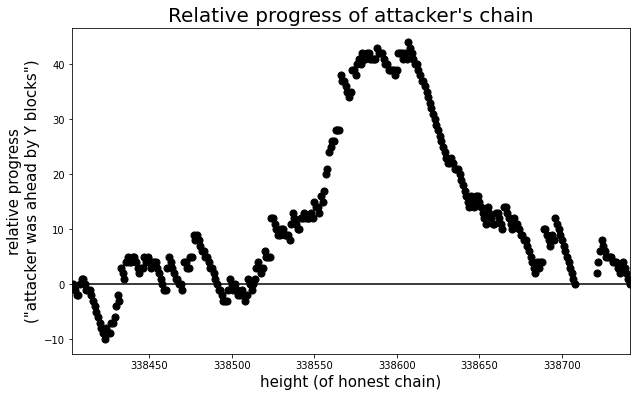

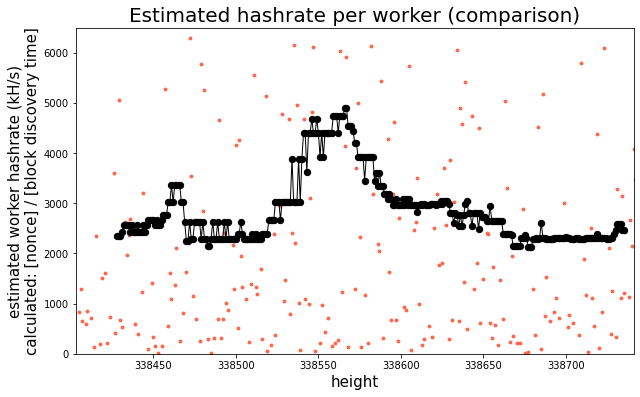

In [26]:
isli.scatter(analysis_df['abandoned_height'], analysis_df['attacker_lead'], xlabel='height (of honest chain)', ylabel='relative progress\n("attacker was ahead by Y blocks")', markersize=50, markercolor='k', figsize=(10,6), title="Relative progress of attacker's chain");
leadDataFrame = analysis_df[analysis_df['attacker_lead']>0]
#plt.scatter(leadDataFrame['abandoned_height'], leadDataFrame['attacker_lead'], s=50, color='g');
plt.axhline(y=0, color='k');
plt.xlim((min(attack_blocks['height']), max(attack_blocks['height'])));

rolling_average_width = 50
nonce_threshold = 1e9

# First plot the honest blocks
honest_blocks_df = control_blocks.append(abandoned_blocks)
honest_blocks_df = honest_blocks_df.sort_values(by='height', ascending=True)
honest_blocks_df['discovery_time'] = honest_blocks_df['time'].diff()
honest_blocks_df['estimated_hashes_per_sec'] = honest_blocks_df['nonce']  / honest_blocks_df['discovery_time']
honest_blocks_df = honest_blocks_df[honest_blocks_df['nonce']  < nonce_threshold]
honest_heights = honest_blocks_df['height']
isli.scatter(honest_blocks_df['height'][1::]-rolling_average_width/2, honest_blocks_df['estimated_hashes_per_sec'][1::]/1000, 
             rollingMedianBinWidth=None, xlabel='height', ylabel='estimated worker hashrate (kH/s)\ncalculated: [nonce] / [block discovery time]', markercolor='w', # << Note that this hides the markers!
             figsize=(10,6), title='Estimated hashrate per worker (comparison)', yscale='linear', ylim=(0, 1e7))
np.nanmedian(honest_blocks_df['estimated_hashes_per_sec'])
xlim_width = 1000
plt.xlim((first_attack_block-xlim_width,last_attack_block+xlim_width));

# Now add the attacker blocks
plt.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000, color='tomato', s = 8)
temporaryDataFrame = pd.DataFrame()
temporaryDataFrame['xData'] = attacker_blocks_df['height'][1::]-rolling_average_width/2
temporaryDataFrame['yData'] = attacker_blocks_df['estimated_hashes_per_sec'][1::]/1000
temporaryDataFrame.sort_values(by='xData', ascending=True, inplace=True)
trace = plt.scatter(temporaryDataFrame.xData,
                    temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
                    color='k', s=40)
trace = plt.plot(temporaryDataFrame.xData, temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
         color='k',linewidth=1)
plt.xlim((min(attack_blocks['height']), max(attack_blocks['height'])));
plt.ylim((0,0.65e4));

### Notes
Early block - 337396 on 15 Jan

Ramp from 12-Jan (336500) to 16-Jan

Attack starts 338403 on 19-Jan

### Wider view to see if higher-hashrate-per-worker equipment was brought online between the 12th and the 16th 

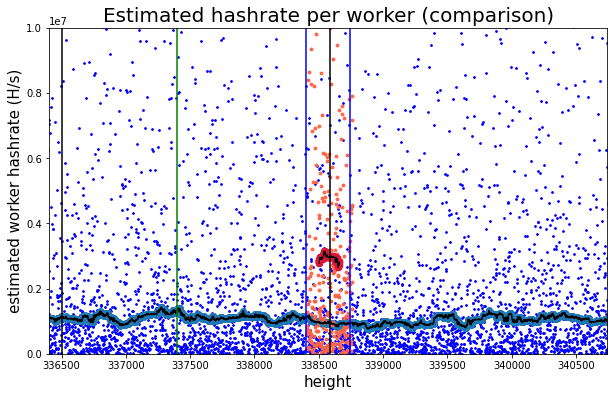

In [27]:
rolling_average_width = 200
nonce_threshold = 1e9
xlim_width = 2000

# First plot the honest blocks
honest_blocks_df = control_blocks.append(abandoned_blocks)
honest_blocks_df = honest_blocks_df.sort_values(by='height', ascending=True)
honest_blocks_df['discovery_time'] = honest_blocks_df['time'].diff()
honest_blocks_df['estimated_hashes_per_sec'] = honest_blocks_df['nonce']  / honest_blocks_df['discovery_time']
honest_blocks_df = honest_blocks_df[honest_blocks_df['nonce']  < nonce_threshold]
honest_heights = honest_blocks_df['height']
isli.scatter(honest_blocks_df['height'][1::]-rolling_average_width/2, honest_blocks_df['estimated_hashes_per_sec'][1::], 
             rollingMedianBinWidth=rolling_average_width, xlabel='height', ylabel='estimated worker hashrate (H/s)', markercolor='b', 
             figsize=(10,6), title='Estimated hashrate per worker (comparison)', yscale='linear', ylim=(0, 1e7))
plt.axvline(x=min(attack_blocks['height']), color='b')
plt.axvline(x=max(attack_blocks['height']), color='b')
np.nanmedian(honest_blocks_df['estimated_hashes_per_sec'])
plt.xlim((first_attack_block-xlim_width,last_attack_block+xlim_width));

# Now add the attacker blocks
plt.scatter(attacker_blocks_df['height'][1::], attacker_blocks_df['estimated_hashes_per_sec'][1::], color='tomato', s = 8)
temporaryDataFrame = pd.DataFrame()
temporaryDataFrame['xData'] = attacker_blocks_df['height'][1::]-rolling_average_width/2
temporaryDataFrame['yData'] = attacker_blocks_df['estimated_hashes_per_sec'][1::]
temporaryDataFrame.sort_values(by='xData', ascending=True, inplace=True)
trace = plt.scatter(temporaryDataFrame.xData,
                    temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
                    color='crimson', s=40)
trace = plt.plot(temporaryDataFrame.xData, temporaryDataFrame['yData'].rolling(rolling_average_width).median(),
         color='k',linewidth=1)
plt.axvline(x=338590, color='k');
plt.axvline(x=337396, color='g');
plt.axvline(x=336500, color='k');

In [28]:
### General analysis of hashrate distributions

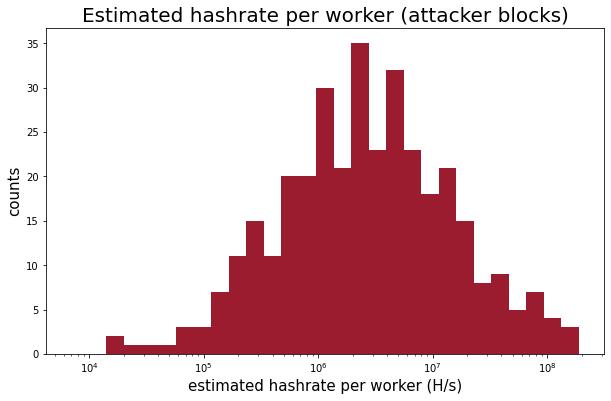

In [29]:
without_outliers_df = attacker_blocks_df[attacker_blocks_df['estimated_hashes_per_sec'] < 2e8]
histData = without_outliers_df['estimated_hashes_per_sec'][1::]
# uncomment next line for linear plot
# isli.hist(histData, xlabel='estimated hashrate per worker (H/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (attacker blocks)');
bins = np.logspace(np.log10(min(histData)), np.log10(max(histData)), 30)
isli.hist(list(histData), xlabel='estimated hashrate per worker (H/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (attacker blocks)', xscale='log', bins=bins);

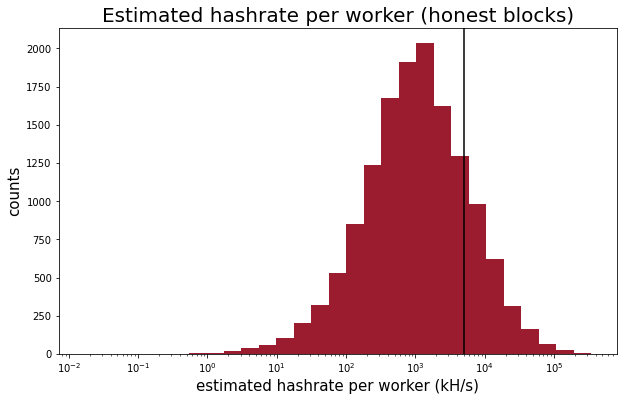

In [30]:
histData = honest_blocks_df['estimated_hashes_per_sec'][1::]/1000
# uncomment next line for linear plot
# isli.hist(histData, xlabel='estimated hashrate per worker (H/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (attacker blocks)');
# bins = np.logspace(np.log10(min(histData)), np.log10(max(histData)), 30)
bins = np.logspace(np.log10(min(histData)), np.log10(max(histData)), 30)
isli.hist(list(histData), xlabel='estimated hashrate per worker (kH/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (honest blocks)', xscale='log', bins=bins);
plt.axvline(x=5000, color='k');

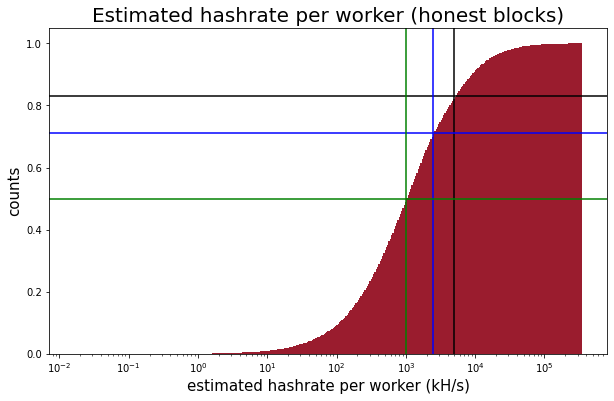

In [31]:
histData = honest_blocks_df['estimated_hashes_per_sec'][1::]/1000
# uncomment next line for linear plot
# isli.hist(histData, xlabel='estimated hashrate per worker (H/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (attacker blocks)');
bins = np.logspace(np.log10(min(histData)), np.log10(max(histData)), 400)
isli.hist(list(histData), xlabel='estimated hashrate per worker (kH/s)', ylabel='counts',color=firo_red_array, figsize=(10,6), title='Estimated hashrate per worker (honest blocks)', xscale='log', bins=bins, cumulative=True, density=True);
plt.axvline(x=5000, color='k')
plt.axhline(y=0.83, color='k')
plt.axvline(x=2500, color='b')
plt.axhline(y=0.71, color='b')
plt.axhline(y=0.50, color='g')
plt.axvline(x=1000, color='g');